# Example:

In [6]:
import numpy as np

from bnn_trust_regions.candidate_region_identification import IdentGifSettings, SisoCandidateRegionIdentification
from bnn_trust_regions.gaussian import UnivariateGaussian
from bnn_trust_regions.io_data import IOData
from bnn_trust_regions.model_evaluator import ModelEvaluator, UseAorB
from bnn_trust_regions.plot_candidate_regions import ErrorbarPlotSettings, PlotSettings, DistributionPlotSettings
from bnn_trust_regions.stat_test_settings import StatTestSettings
from bnn_trust_regions.utils import save_load
from bnn_trust_regions.wasserstein_dist import WassersteinDistance

Load example Data

In [7]:
########################################################################################################
# load test data
########################################################################################################
# folder with some example data and predictions
data_folder = "example_data"
# load test data
test_data_file_name = "nn_test"
test_input, test_output = save_load.load_io_data(data_folder, test_data_file_name)
test_data = IOData(input=test_input, output=test_output)

# load training data
train_data_file_name = "nn_train"
train_input, train_output = save_load.load_io_data(data_folder, train_data_file_name)
train_data = IOData(input=train_input, output=train_output)

# load predictions
mcmc_file_name = "mcmc_test"
pred_mcmc = save_load.load_sampled_predictions(data_folder, mcmc_file_name)
svi_file_name = "meanfield_svi_test"
pred_svi = save_load.load_sampled_predictions(data_folder, svi_file_name)
pbp_file_name = "pbp_test"
pred_pbp_mean, pred_pbp_var = save_load.load_sampled_predictions(data_folder, pbp_file_name)
pred_pbp = UnivariateGaussian(mean=pred_pbp_mean, var=pred_pbp_var)

Settings and Hyperparameter

In [8]:
########################################################################################################
#  change predictions and test data and hyperparameters
# for region identification and statistical testing here
########################################################################################################

# set wasserstein distance settings
p_norm = 1
parallel_computing = True
verbose = False
ws_dist_settings1 = WassersteinDistance(
    p_norm=p_norm, parallel_computing=parallel_computing, verbose=verbose)


# candidate region identification settings
min_points_per_region = 200
smoothing_window_size = 50
plot_gif = True

# display gif of regions identification critical distance
plot_folder1 = "eval1_plots"
plot_folder2 = "eval2_plots"
file_name = "crit_dist"
dpi = 200
fps = 2
loop = 0  # 0 for infinite loop
gif_settings1 = IdentGifSettings(
    path=plot_folder1, file_name=file_name, dpi=dpi, fps=fps, loop=loop)


region_ident1 = SisoCandidateRegionIdentification(
    min_points_per_region=min_points_per_region, smoothing_window_size=smoothing_window_size, verbose=plot_gif, gif_settings=gif_settings1)


# statistical test settings
alpha = 0.01  # significance level of 1%
confidence_interval = 0.95  # test the 95% confidence interval
stat_test_settings = StatTestSettings(alpha=alpha, confidence_interval=confidence_interval)



Plot settings

In [9]:
error_bar_plot_settings = ErrorbarPlotSettings(
        # label
        anees_label=r'ANEES is $\chi^2$',
        anees_label_notchi2=r'ANEES is not $\chi^2$',
        annes_errorbar_label='ANEES Bounds',
        split_label='Region Split',
        out_of_scope_label='ANEES o.s.',
        anees_y_label='ANEES',
        # colors
        anees_bar_color='tab:orange',
        anees_marker_color='tab:blue',
        binom_bar_color='tab:purple',
        binom_marker_color='tab:red',
    )
plot_settings = PlotSettings(
    image_format='svg',  # image format of the plots
    # plot_folder='eval1_plots',  # folder where the plots are saved
    confidence_interval=0.95,
    # settings to plot the predictions and the mean of the ground truth
    ground_truth_plot_settings=DistributionPlotSettings(
        mean_color='tab:orange',
        mean_linestyle='-',
        mean_label=r'$y=x^3$',),  # label for mean value of ground truth
    wasserstein_plot_settings=DistributionPlotSettings(
        mean_color='k',
        mean_linestyle='-',
        mean_label=r'$W_1^\text{GT}$',),  # label for wasserstein distance between ground truth distribution and predictive distribution
    error_bar_plot_settings=error_bar_plot_settings,
    )

models to be tested

In [15]:

pred_a = pred_mcmc # reference model
pred_b = [pred_svi, pred_pbp] # list of models to compare with reference model
plot_folder = ['eval1_plots', 'eval2_plots'] # list of folders where the plots are saved
model_a_names = 'MCMC' # name of reference model
model_b_names = ['SVI', 'PBP'] # list of model names


Ground truth (only for plotting)

In [16]:
ground_truth_mean = np.power(test_data.input, 3).reshape(1, -1)
ground_truth_distribution = UnivariateGaussian(mean=ground_truth_mean.squeeze(), var=9.)

1494.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1494.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
1494.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1494.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - 

Model MCMC:
Binomial test results:
+-------+-------+-------------------+---------+-------------+--------------+------------------------+
| x_min | x_max | proportion inside | p-value | prop CI low | prop CI high | calibrated predictions |
+-------+-------+-------------------+---------+-------------+--------------+------------------------+
| -6.00 | -4.89 |        0.91       |   0.01  |     0.85    |     0.95     |          True          |
| -4.89 | -3.77 |        0.92       |   0.03  |     0.86    |     0.96     |          True          |
| -3.77 | -2.66 |        0.91       |   0.03  |     0.86    |     0.96     |          True          |
| -2.66 | -1.54 |        0.91       |   0.01  |     0.84    |     0.95     |         False          |
| -1.54 | -0.54 |        1.00       |   0.00  |     0.97    |     1.00     |         False          |
| -0.54 |  0.47 |        1.00       |   0.00  |     0.97    |     1.00     |         False          |
|  0.47 |  1.47 |        1.00       |   0.00  |

/mnt/c/Users/be5831/Documents/SoftwareCampus/PythonProjects/BNN_trust_regions/bnn_trust_regions/candidate_region_identification.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Model MCMC:
Binomial test results:
+-------+-------+-------------------+---------+-------------+--------------+------------------------+
| x_min | x_max | proportion inside | p-value | prop CI low | prop CI high | calibrated predictions |
+-------+-------+-------------------+---------+-------------+--------------+------------------------+
| -6.00 | -4.89 |        0.91       |   0.01  |     0.85    |     0.95     |          True          |
| -4.89 | -3.77 |        0.92       |   0.03  |     0.86    |     0.96     |          True          |
| -3.77 | -2.66 |        0.91       |   0.03  |     0.86    |     0.96     |          True          |
| -2.66 | -1.54 |        0.91       |   0.01  |     0.84    |     0.95     |         False          |
| -1.54 | -0.54 |        1.00       |   0.00  |     0.97    |     1.00     |         False          |
| -0.54 |  0.47 |        1.00       |   0.00  |     0.97    |     1.00     |         False          |
|  0.47 |  1.47 |        1.00       |   0.00  |

ValueError: operands could not be broadcast together with shapes (2400,) (2,) 

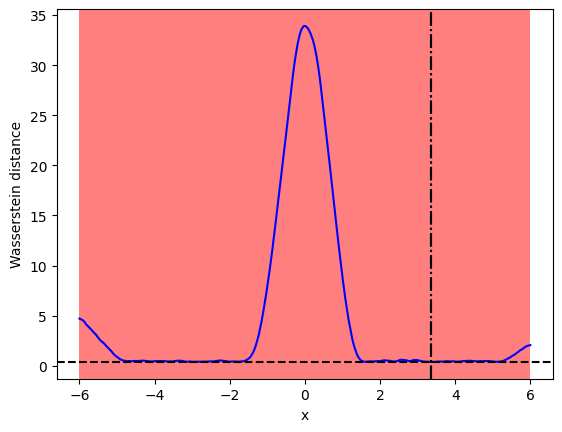

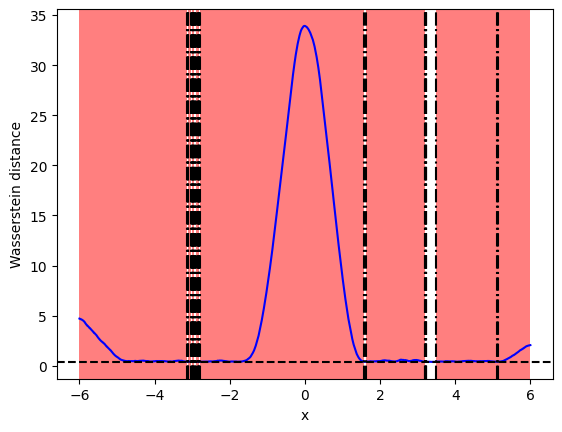

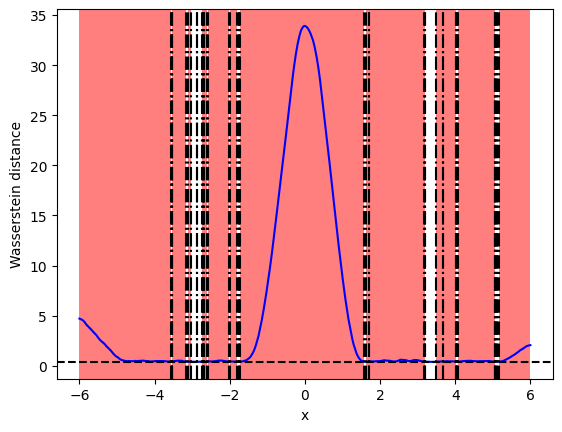

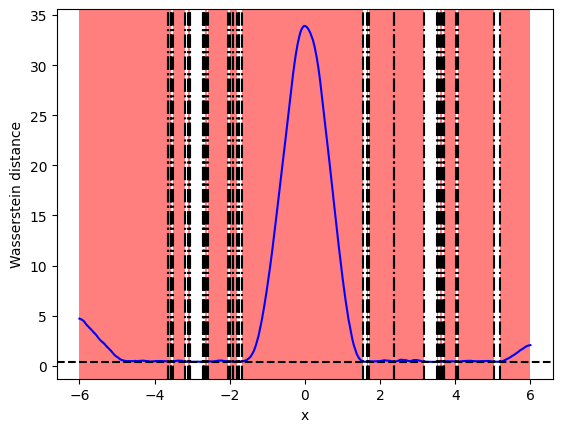

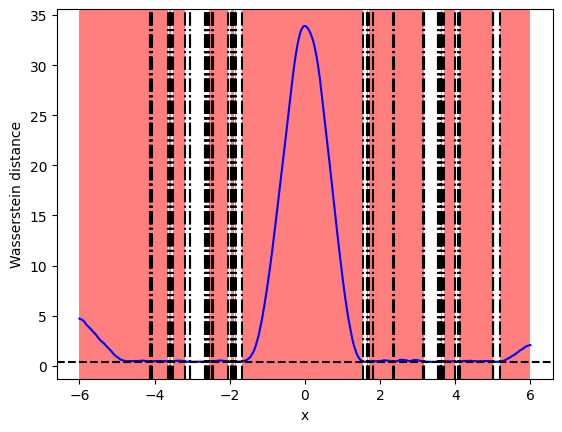

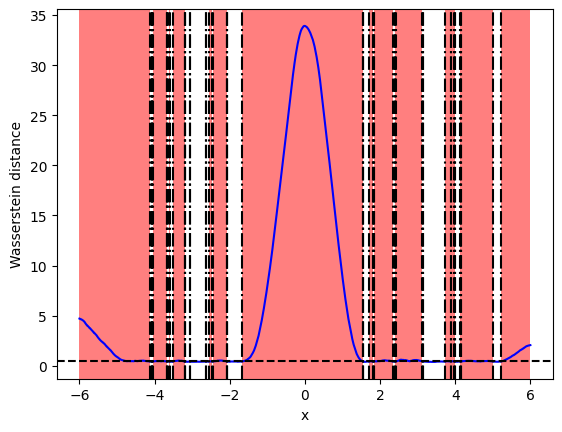

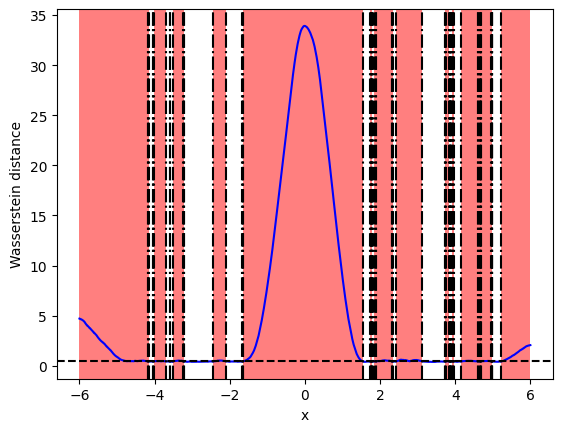

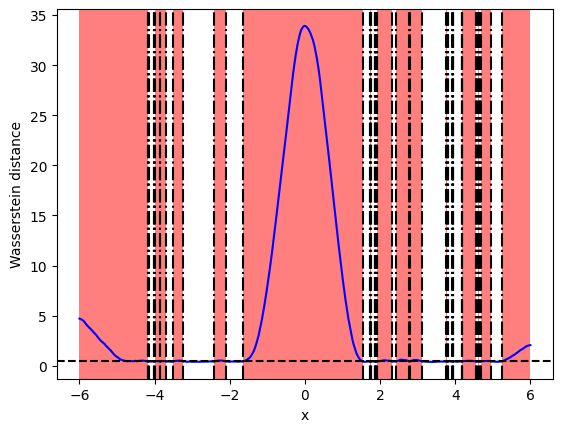

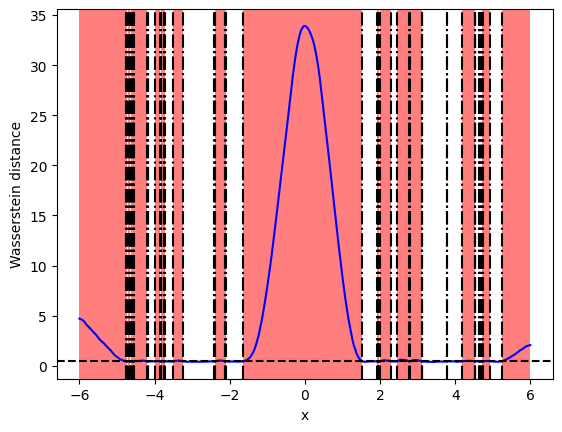

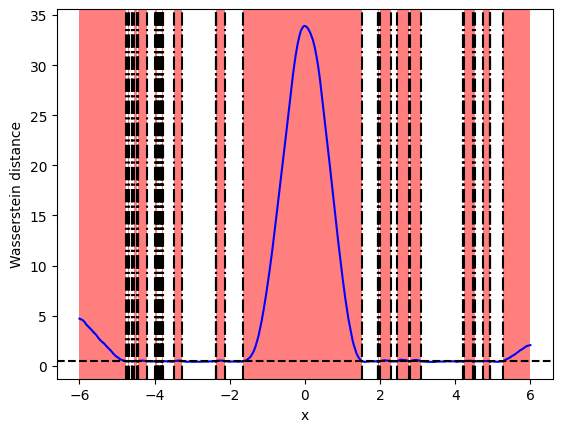

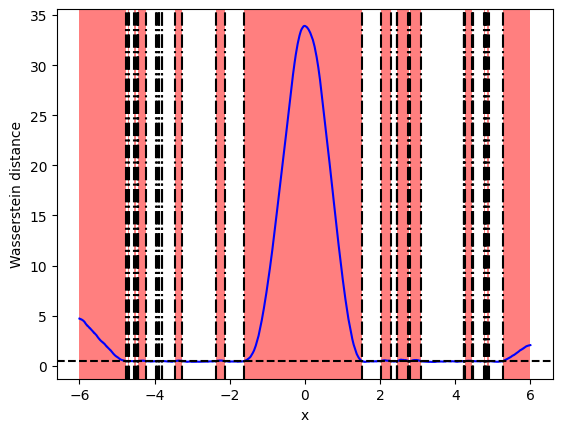

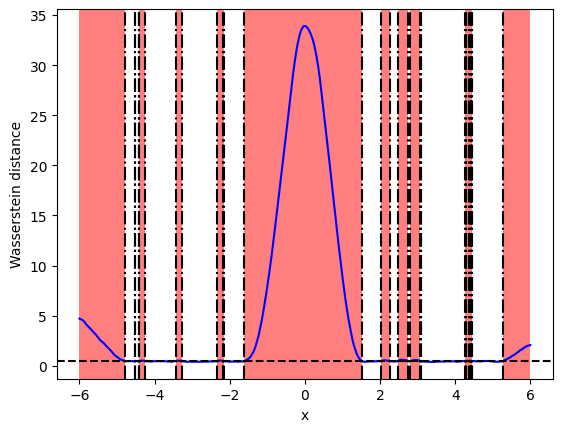

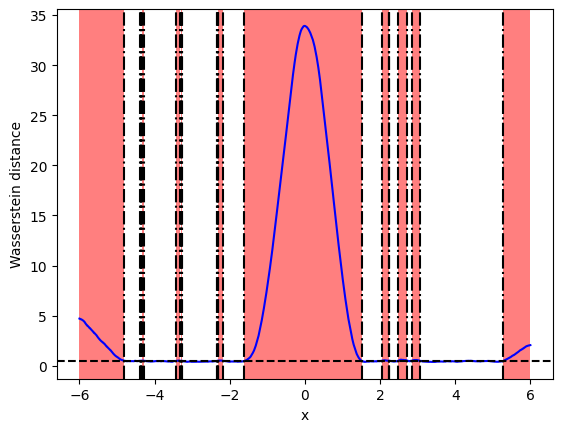

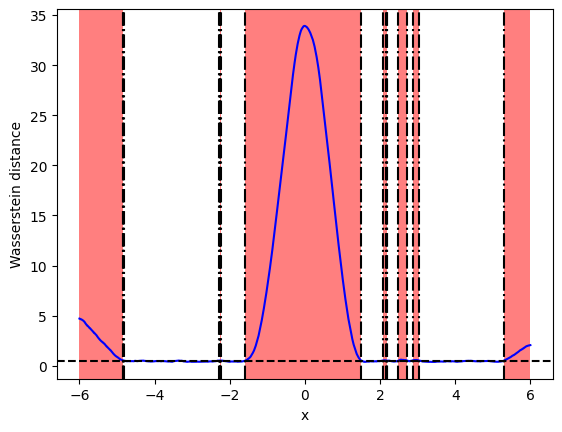

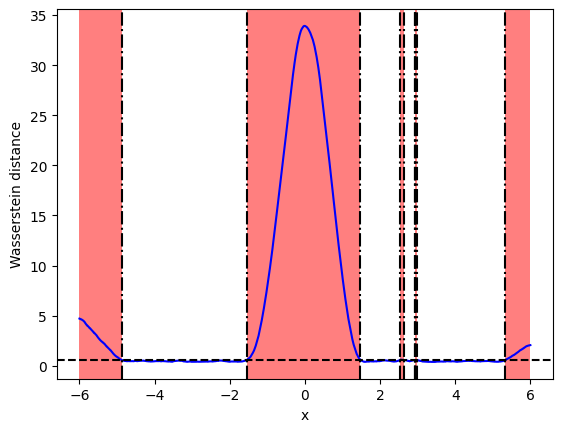

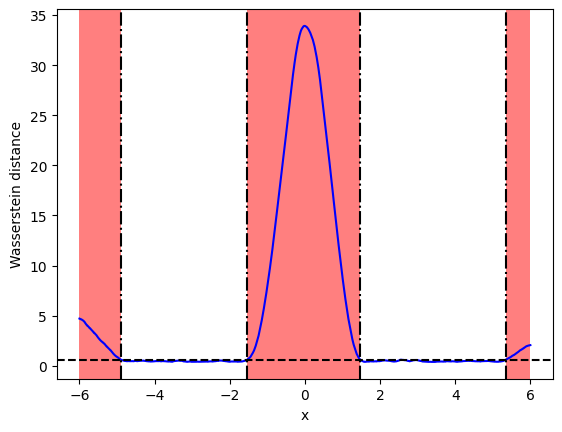

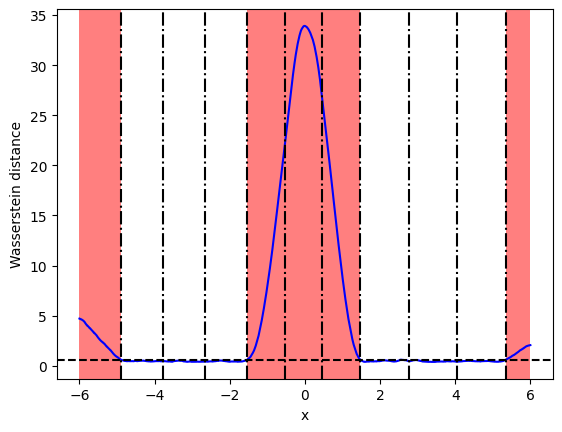

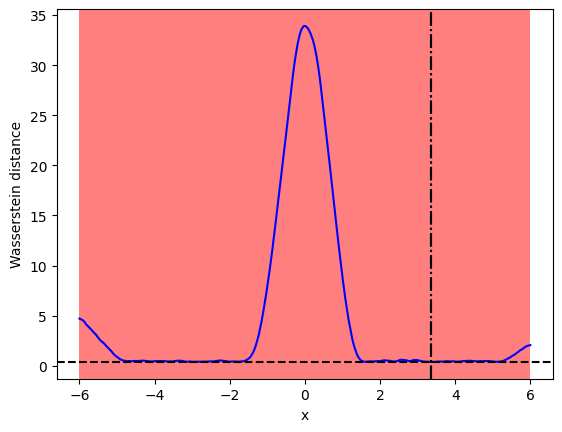

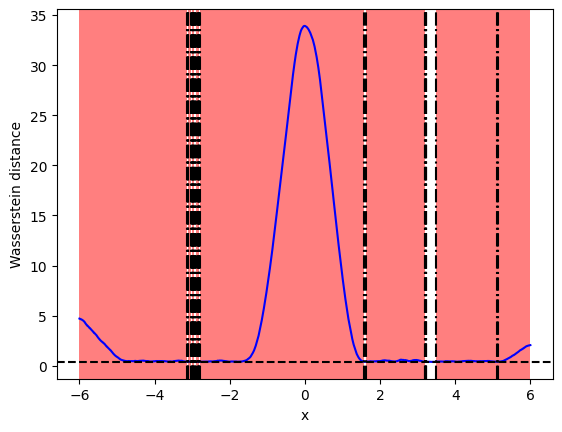

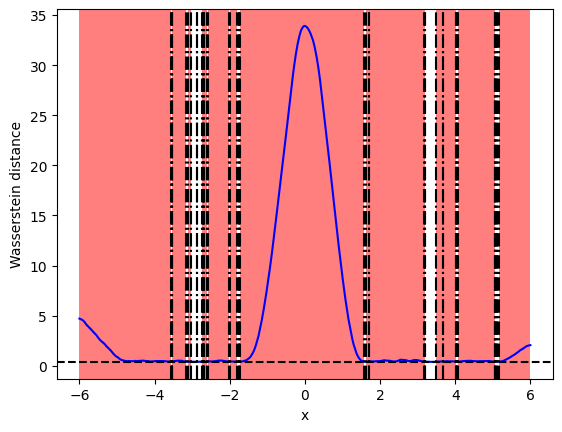

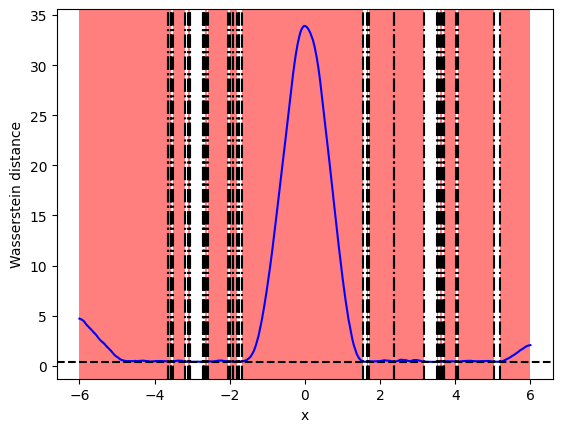

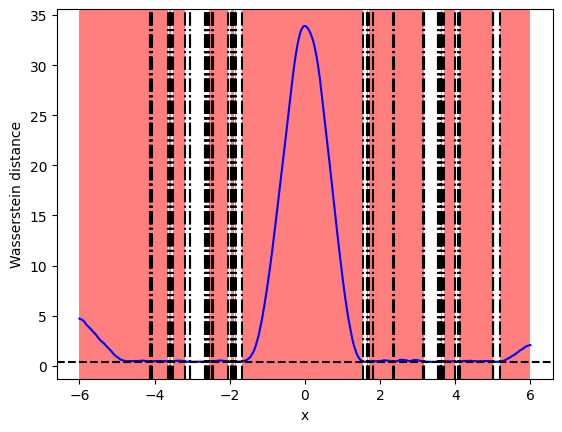

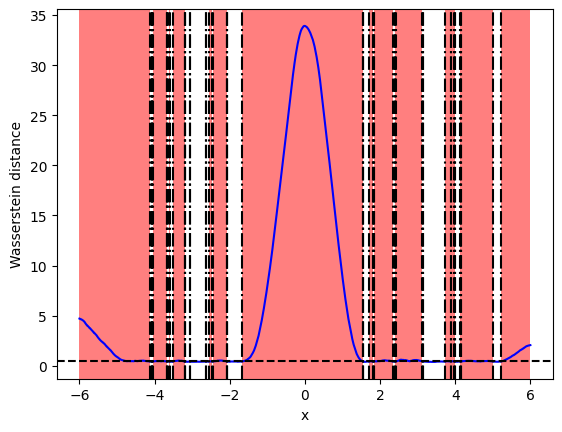

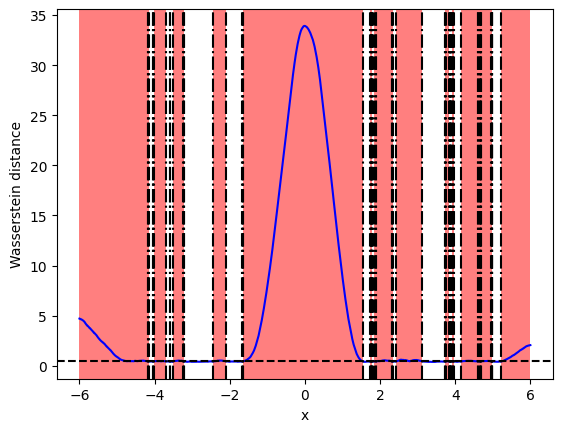

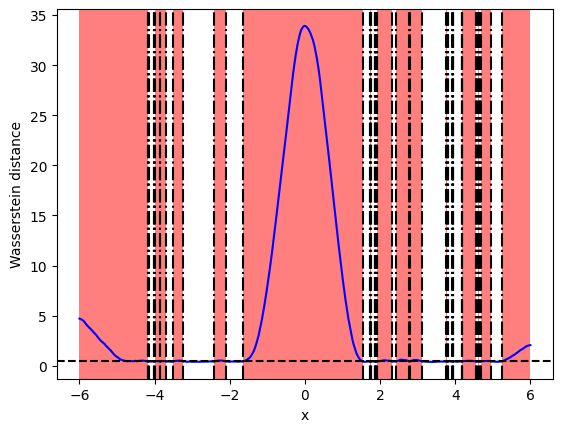

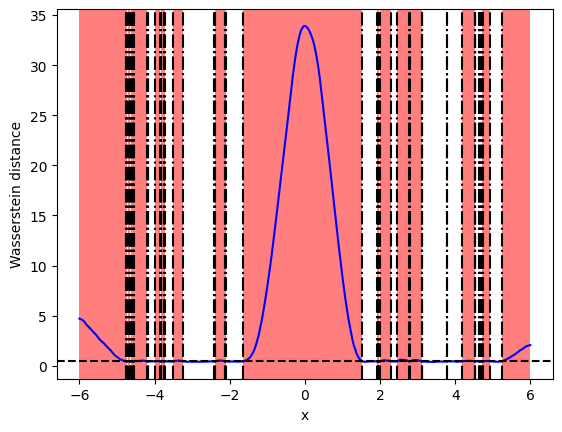

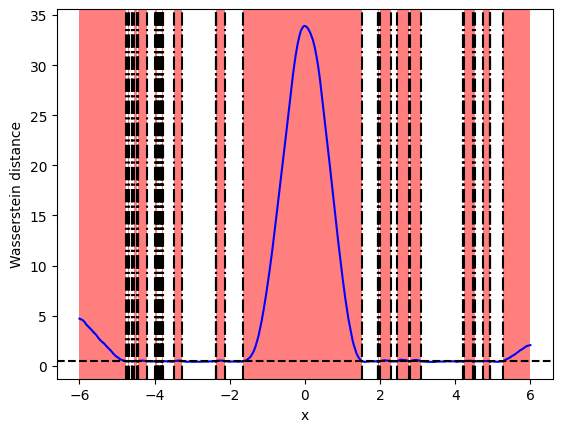

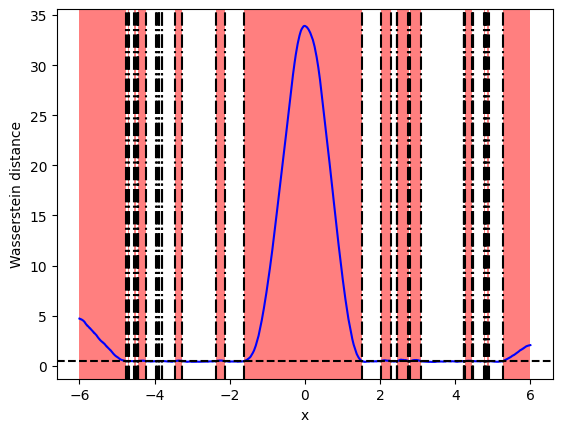

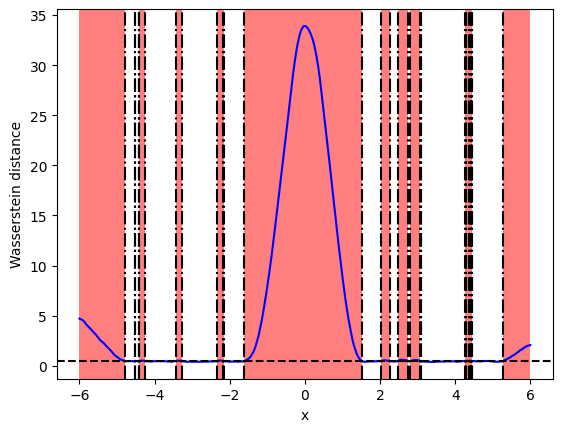

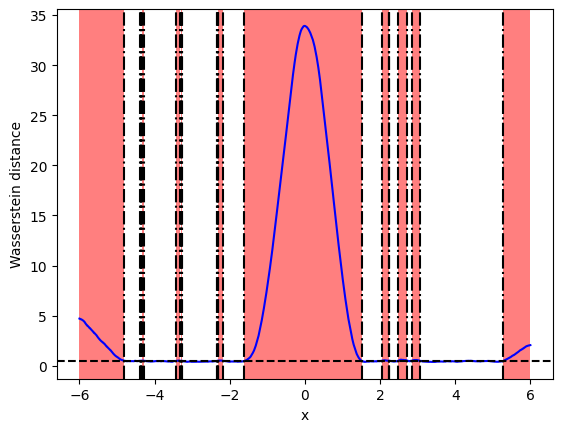

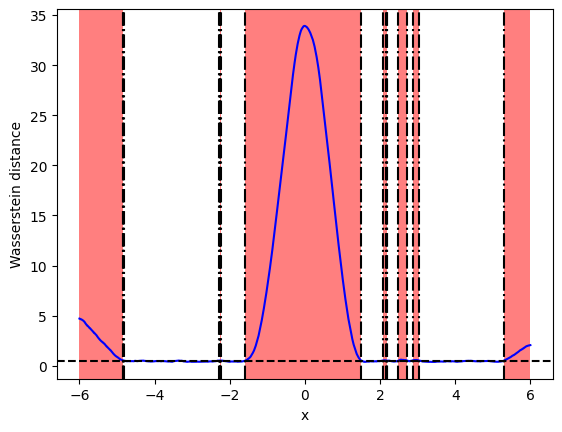

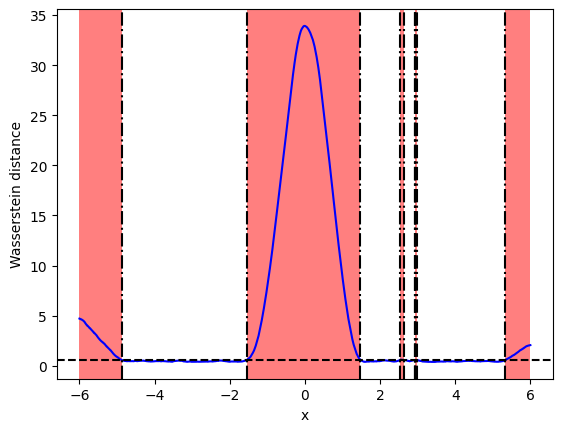

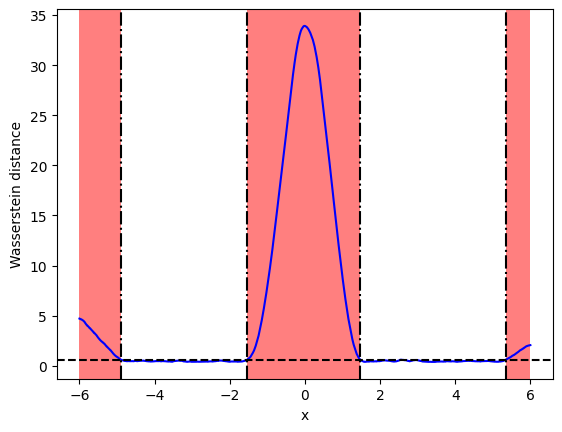

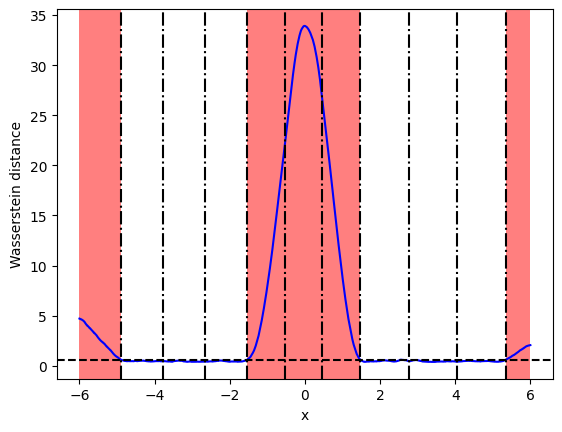

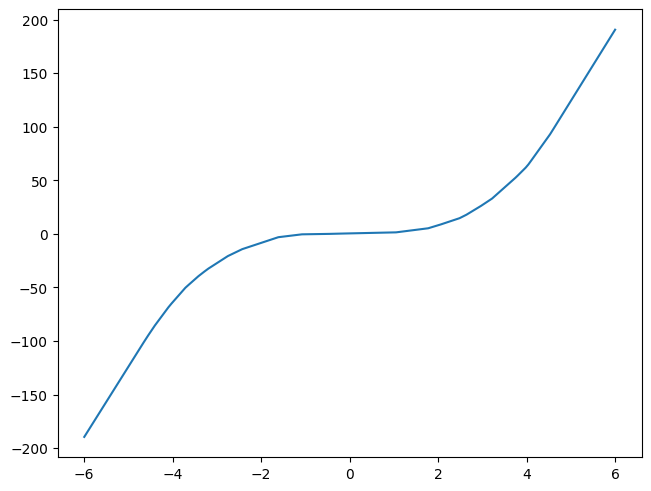

In [18]:
for idx, preds in enumerate(pred_b):
    # use different plot folder for each model
    plot_settings.plot_folder = plot_folder[idx]

    # set model names 
    model_names=(model_a_names, model_b_names[idx])

    # set the models and get the wasserstein distance between the predictions
    model_evaluator1 = ModelEvaluator(
        predictions_a=pred_a, predictions_b=preds,
        wasserstein_distance=ws_dist_settings1, test_data=test_data)
    model_evaluator1.calc_wasserstein_distance()

    # calculate candidate regions and plot gif of critical distance
    model_evaluator1.calc_canidate_regions(region_ident=region_ident1)

    # calculate statistical tests (ANEES and binomial test)
    model_evaluator1.calc_statistical_tests(
        stat_test_settings=stat_test_settings, )
    
    # print results to console
    model_evaluator1.print_statistical_tests(model_names=model_names)  

    # plot results to files
    model_evaluator1.plot_statistical_tests(
        plot_settings=plot_settings,
          ground_truth=ground_truth_distribution, 
          model_names=model_names)

    
    

Evaluate Model: SVI as approximation model

Binomial test results:
+-------+-------+-------------------+---------+-------------+--------------+------------------------+
| x_min | x_max | proportion inside | p-value | prop CI low | prop CI high | calibrated predictions |
+-------+-------+-------------------+---------+-------------+--------------+------------------------+
| -6.00 | -4.89 |        0.91       |   0.01  |     0.85    |     0.95     |          True          |
| -4.89 | -3.77 |        0.92       |   0.03  |     0.86    |     0.96     |          True          |
| -3.77 | -2.66 |        0.91       |   0.03  |     0.86    |     0.96     |          True          |
| -2.66 | -1.54 |        0.91       |   0.01  |     0.84    |     0.95     |         False          |
| -1.54 | -0.54 |        1.00       |   0.00  |     0.97    |     1.00     |         False          |
| -0.54 |  0.47 |        1.00       |   0.00  |     0.97    |     1.00     |         False          |
|  0.47 |  1.47 |        1.00       |   0.00  |     0.97   

/mnt/c/Users/be5831/Documents/SoftwareCampus/PythonProjects/BNN_trust_regions/bnn_trust_regions/plot_candidate_regions.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(region.x_min, region.x_max, alpha=plt_settings.region_opacity,
/mnt/c/Users/be5831/Documents/SoftwareCampus/PythonProjects/BNN_trust_regions/bnn_trust_regions/plot_candidate_regions.py:156: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.axvspan(region.x_min, region.x_max, alpha=plt_settings.region_opacity,


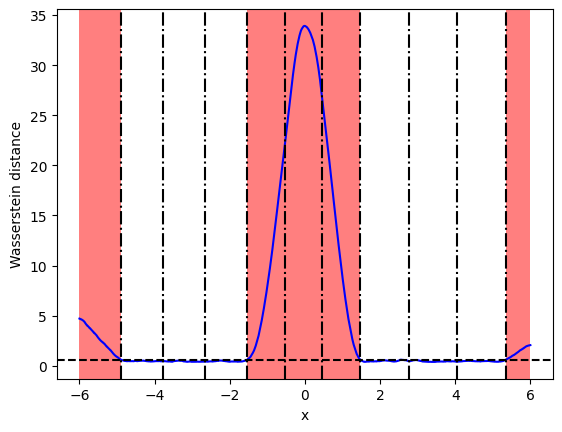

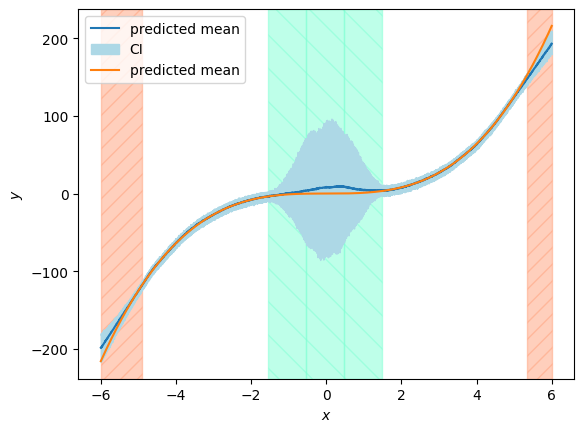

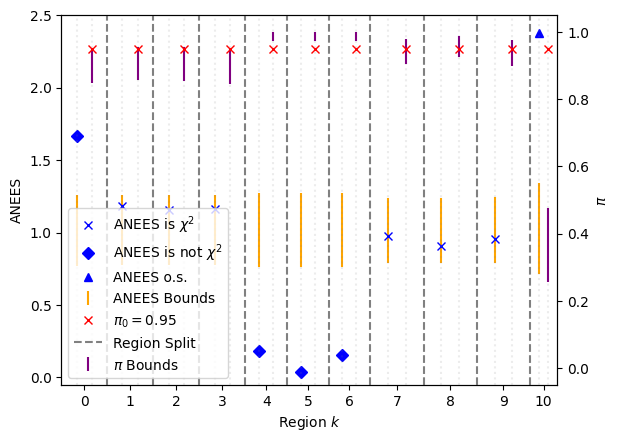

In [4]:
########################################################################################################
# evaluate predictions from mcmc and svi
########################################################################################################
model_evaluator1 = ModelEvaluator(
    predictions_a=pred_a, predictions_b=pred_b1, wasserstein_distance=ws_dist_settings1, test_data=test_data)

# wasserstein distance between reference and approximation model
model_evaluator1.calc_wasserstein_distance()

# calculate candidate regions and plot gif of critical distance
model_evaluator1.calc_canidate_regions(region_ident=region_ident1)
model_evaluator1.calc_statistical_tests(
    stat_test_settings=stat_test_settings, use_a_or_b=use_a_or_b)
model_evaluator1.print_statistical_tests()  # print results to console
model_evaluator1.plot_statistical_tests()  # plot candidate regions
########################################################################################################

Evaluate Model: PBP as approximation model

Binomial test results:
+-------+-------+-------------------+---------+-------------+--------------+------------------------+
| x_min | x_max | proportion inside | p-value | prop CI low | prop CI high | calibrated predictions |
+-------+-------+-------------------+---------+-------------+--------------+------------------------+
| -6.00 | -4.91 |        0.91       |   0.01  |     0.85    |     0.95     |         False          |
| -4.91 | -3.75 |        0.92       |   0.03  |     0.86    |     0.96     |          True          |
| -3.75 | -2.59 |        0.92       |   0.03  |     0.86    |     0.96     |          True          |
| -2.59 | -1.43 |        0.91       |   0.01  |     0.85    |     0.95     |         False          |
| -1.43 | -0.00 |        1.00       |   0.00  |     0.98    |     1.00     |         False          |
| -0.00 |  1.42 |        1.00       |   0.00  |     0.98    |     1.00     |         False          |
|  1.42 |  2.73 |        0.95       |   1.00  |     0.90   

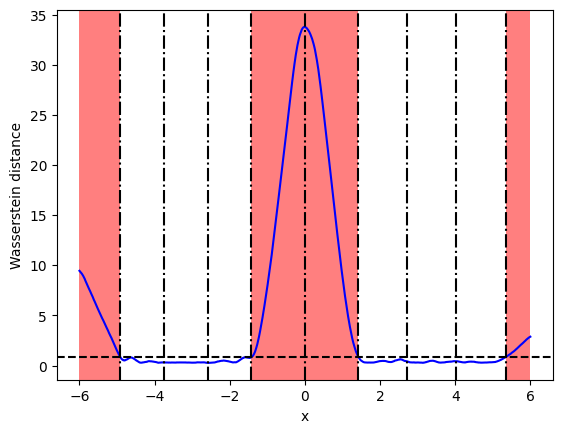

In [5]:
########################################################################################################
# evaluate predictions from mcmc and pbp
# mcmc as reference model
# pred_b2 = pred_pbp  # pbp as approximation model
########################################################################################################

model_evaluator2 = ModelEvaluator(
    predictions_a=pred_a, predictions_b=pred_b2, test_data=test_data)

model_evaluator2.set_distance_settings(ws_dist_settings1)
model_evaluator2.calc_wasserstein_distance()

model_evaluator2.calc_canidate_regions(region_ident=region_ident2)
model_evaluator2.calc_statistical_tests(
    stat_test_settings=stat_test_settings, use_a_or_b=use_a_or_b)
model_evaluator2.print_statistical_tests()  # print results to console
########################################################################################################